In [1]:
from chainer import Variable, optimizers,cuda
import cupy

import chainer.functions as F
from sklearn.datasets import fetch_mldata
import numpy
from virtual_adversarial_trainer import VirtualAdversarialTrainer
from my_batch_normalization import MyBatchNormalization
from nn import NN


# Define NN

In [2]:
class stdNN(NN):
    def __init__(self):
        super(NN,self).__init__(l1 = F.Linear(784,1200,nobias=True),
                                b1 = MyBatchNormalization(1200, decay=0.9, eps=1e-06),
                                l2 = F.Linear(1200,600,nobias=True),
                                b2 = MyBatchNormalization(600, decay=0.9, eps=1e-06),
                                l3 = F.Linear(600,300,nobias=True),
                                b3 = MyBatchNormalization(300, decay=0.9, eps=1e-06),
                                l4 =F.Linear(300,150,nobias=True),
                                b4 = MyBatchNormalization(150, decay=0.9, eps=1e-06),
                                l5 =F.Linear(150,10),
                                b5 = MyBatchNormalization(10, decay=0.9, eps=1e-06))
        self.to_gpu()
    def y_given_x(self,x,test,upd_batch_est=True):
        h = self.l1(x)
        h = self.b1(h,test,False,upd_batch_est)
        h = F.relu(h)
        h = self.l2(h)
        h = self.b2(h,test,False,upd_batch_est)
        h = F.relu(h)
        h = self.l3(h)
        h = self.b3(h,test,False,upd_batch_est)
        h = F.relu(h)
        h = self.l4(h)
        h = self.b4(h,test,False,upd_batch_est)
        h = F.relu(h)
        h = self.l5(h)
        h = self.b5(h,test,False,upd_batch_est)
        return h
    
    def py_given_y(self,y):
        return F.softmax(y)

#Initialize NN and virtual adversarial trainer


In [3]:
numpy.random.seed(1)

model = stdNN()
with cupy.cuda.Device(1):
    model.to_gpu()
virtual_adversarial_trainer = VirtualAdversarialTrainer(model,out_act_type='Softmax',epsilon=2.1,
                                                                            norm_constraint_type='L2',lamb=numpy.float(1.0),
                                                                            xi=numpy.float(1e-6),num_power_iteration=1)
optimizer = optimizers.Adam(alpha=0.002)
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
x_all = mnist.data.astype(numpy.float32) / 255
y_all = mnist.target.astype(numpy.int32)
x_train, x_test = numpy.split(x_all, [60000])
y_train, y_test = numpy.split(y_all, [60000])
optimizer.setup(model)

#Train NN

In [4]:
virtual_adversarial_training = True

batchsize = 100 
for epoch in xrange(100):
    indexes = numpy.random.permutation(60000)
    n_batch = indexes.shape[0]/batchsize
    sum_nll = 0
    sum_cost_vadv = 0
    sum_accuracy = 0

    for i in xrange(0, 60000, batchsize):
        x_batch = x_train[indexes[i : i + batchsize]]
        y_batch = y_train[indexes[i : i + batchsize]]
        with cupy.cuda.Device(1):
            x_batch = cupy.array(x_batch)
            y_batch = cupy.array(y_batch)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        nll, cost_vadv= virtual_adversarial_trainer.cost_virtual_adversarial_training(x_batch,y_batch,unchain_clean_y=True)
        #nll, cost_vadv= virtual_adversarial_trainer.cost_adversarial_training(x_batch,y_batch)
        sum_nll += nll.data*batchsize
        sum_cost_vadv += cost_vadv.data*batchsize
        sum_accuracy += virtual_adversarial_trainer.accuracy(x_batch,y_batch).data*batchsize

        if(virtual_adversarial_training==True):
            loss = nll+cost_vadv 
        else:
            loss = nll # Maximum Likelihood Estimation
            
        optimizer.zero_grads()
        loss.backward()
        optimizer.update()
    optimizer.alpha *=0.9
    
    sum_test_accuracy = 0
    for i in xrange(0, 10000, batchsize):
        x_batch = x_test[i : i + batchsize]
        y_batch = y_test[i : i + batchsize]
        with cupy.cuda.Device(1):
            x_batch = cupy.array(x_batch)
            y_batch = cupy.array(y_batch)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        sum_test_accuracy  += virtual_adversarial_trainer.accuracy(x_batch,y_batch).data*batchsize
    
    print '[epoch ' +  str(epoch) +']' 
    print 'train nll:' + str(sum_nll/60000) + ' train cost_vadv:' + str(sum_cost_vadv/60000)
    print 'train accuracy(%):' + str(sum_accuracy/60000*100) + ' test accuracy(%):' + str(sum_test_accuracy/10000*100)


Exception KeyboardInterrupt in <bound method PooledMemory.__del__ of <cupy.cuda.memory.PooledMemory object at 0x7f06166a8290>> ignored


KeyboardInterrupt: 

#Save the computional graph

In [ ]:
import chainer.computational_graph as c
from graphviz import Source
g = c.build_computational_graph([loss]).dump()
Source(g,filename='computational_graph',).save()

#Visualize virtual adversarial perturbations


/home/miyato-t/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


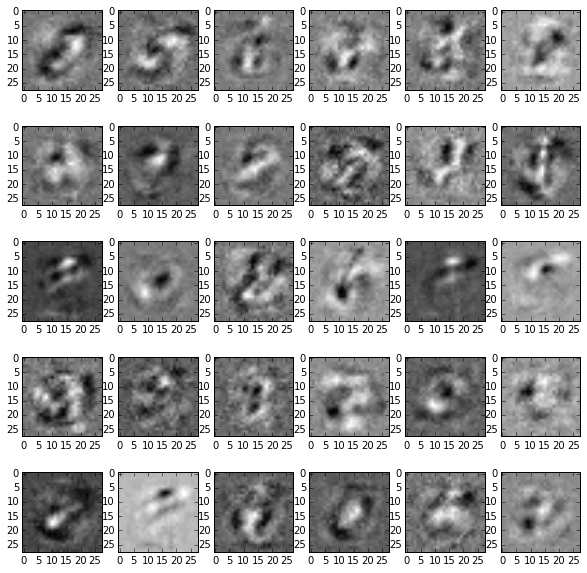

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
indexes = numpy.random.permutation(10000)   
x_batch = x_test[indexes[:30]]
with cupy.cuda.Device(1):
    x_batch = cupy.array(x_batch)
x_batch = Variable(x_batch)

xvadv, ptb = virtual_adversarial_trainer.get_virtual_adversarial_examples(x_batch,test=False)

with cupy.cuda.Device(1):
     ptb = ptb.get()
    
plt.figure(figsize=(10,10))
for i in xrange(30):
    plt.subplot(5,6,i)
    plt.imshow(ptb[i].reshape((28,28)),cmap='binary')
plt.show()

In [9]:
xp = cupy.get_array_module(*x_batch.data)

In [15]:
x_batch.data/x_batch.data.shape[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [5]:
a = x_batch.data.shape[0]

In [6]:
a

100

In [7]:
int(a)

100